<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Configuración de semilla para reproducibilidad
RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

print(f"Dataset shape: {df.shape}")
print(f"Distribución de clases:\n{df['CLASS_LABEL'].value_counts()}")

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']


Dataset shape: (10000, 49)
Distribución de clases:
CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64


In [9]:
class PhishingNeuralNetwork:
    """
    Clase para implementar red neuronal MLP para detección de phishing
    siguiendo la metodología de validación especificada.
    """
    
    def __init__(self, random_state: int = 42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.best_model = None
        self.tuner = None
        self.history = None
        
    def build_model(self, hp):
        """
        Construye modelo con hiperparámetros optimizables según metodología.
        """
        model = keras.Sequential()
        
        # Capa de entrada con normalización
        model.add(layers.InputLayer(input_shape=(self.input_dim,)))
        model.add(layers.BatchNormalization())
        
        # Función de activación según metodología: ['relu', 'tanh', 'logistic']
        activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        
        # Regularización L2 (alpha según metodología: [0.0001, 0.001, 0.01, 0.1])
        l2_reg = hp.Choice('l2_regularization', values=[0.0001, 0.001, 0.01, 0.1])
        
        # Arquitectura de capas ocultas (según metodología: (50,), (100,), (50,50), (100,50), (100,100))
        architecture_choice = hp.Choice('architecture', 
                                      values=['single_50', 'single_100', 'double_50_50', 
                                             'double_100_50', 'double_100_100'])
        
        if architecture_choice == 'single_50':
            model.add(layers.Dense(50, activation=activation, 
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_1'))
        elif architecture_choice == 'single_100':
            model.add(layers.Dense(100, activation=activation,
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_1'))
        elif architecture_choice == 'double_50_50':
            model.add(layers.Dense(50, activation=activation,
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_1'))
            model.add(layers.Dense(50, activation=activation,
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_2'))
        elif architecture_choice == 'double_100_50':
            model.add(layers.Dense(100, activation=activation,
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_1'))
            model.add(layers.Dense(50, activation=activation,
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_2'))
        elif architecture_choice == 'double_100_100':
            model.add(layers.Dense(100, activation=activation,
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_1'))
            model.add(layers.Dense(100, activation=activation,
                                 kernel_regularizer=keras.regularizers.l2(l2_reg),
                                 name='hidden_2'))
        
        # Dropout para regularización adicional
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        model.add(layers.Dropout(dropout_rate))
        
        # Capa de salida para clasificación binaria
        model.add(layers.Dense(1, activation='sigmoid', 
                              kernel_regularizer=keras.regularizers.l2(l2_reg)))
        
        # Tasa de aprendizaje según metodología: [0.001, 0.01, 0.1]
        learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
        
        # Compilación del modelo
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model
    
    def prepare_data(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Prepara los datos según la metodología: 70% entrenamiento, 15% validación, 15% prueba.
        """
        # Primera división: 70% entrenamiento, 30% temporal
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=self.random_state, stratify=y
        )
        
        # Segunda división: 15% validación, 15% prueba del 30% temporal
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=self.random_state, stratify=y_temp
        )
        
        # Normalización de características
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        print(f"Distribución de datos:")
        print(f"Entrenamiento: {X_train_scaled.shape[0]} muestras")
        print(f"Validación: {X_val_scaled.shape[0]} muestras")
        print(f"Prueba: {X_test_scaled.shape[0]} muestras")
        
        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
    
    def optimize_hyperparameters(self, X_train: np.ndarray, y_train: np.ndarray, 
                                X_val: np.ndarray, y_val: np.ndarray, 
                                max_trials: int = 50, epochs: int = 100):
        """
        Optimiza hiperparámetros usando Keras Tuner con validación cruzada estratificada.
        """
        self.input_dim = X_train.shape[1]
        
        # Configuración del tuner (Random Search para eficiencia)
        self.tuner = kt.RandomSearch(
            self.build_model,
            objective='val_loss',  # Cambiamos a una métrica estándar
            max_trials=max_trials,
            directory='phishing_tuning',
            project_name='neural_network_phishing',
            seed=self.random_state
        )
        
        # Callbacks para entrenamiento
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        
        # Búsqueda de hiperparámetros
        print("Iniciando optimización de hiperparámetros...")
        self.tuner.search(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Obtener mejores hiperparámetros
        best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]
        print("\nMejores hiperparámetros encontrados:")
        for param, value in best_hps.values.items():
            print(f"{param}: {value}")
        
        return best_hps
    
    def train_best_model(self, X_train: np.ndarray, y_train: np.ndarray,
                        X_val: np.ndarray, y_val: np.ndarray, 
                        best_hps, epochs: int = 200):
        """
        Entrena el modelo final con los mejores hiperparámetros.
        """
        self.best_model = self.tuner.hypermodel.build(best_hps)
        
        # Callbacks para entrenamiento final
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
        
        # Entrenamiento del modelo final
        print("\nEntrenando modelo final...")
        self.history = self.best_model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        
        return self.best_model
    
    def evaluate_model(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict:
        """
        Evaluación completa del modelo según métricas de la metodología.
        """
        if self.best_model is None:
            raise ValueError("Modelo no entrenado. Ejecute train_best_model primero.")
        
        # Predicciones
        y_pred_proba = self.best_model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # Métricas principales según metodología
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        
        # Métricas complementarias
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        mcc = matthews_corrcoef(y_test, y_pred)
        
        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc_roc,
            'specificity': specificity,
            'mcc': mcc,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        return metrics
    
    def plot_training_history(self):
        """Visualiza el historial de entrenamiento."""
        if self.history is None:
            print("No hay historial de entrenamiento disponible.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        axes[0, 0].plot(self.history.history['loss'], label='Entrenamiento')
        axes[0, 0].plot(self.history.history['val_loss'], label='Validación')
        axes[0, 0].set_title('Pérdida del Modelo')
        axes[0, 0].set_xlabel('Época')
        axes[0, 0].set_ylabel('Pérdida')
        axes[0, 0].legend()
        
        # Accuracy
        axes[0, 1].plot(self.history.history['accuracy'], label='Entrenamiento')
        axes[0, 1].plot(self.history.history['val_accuracy'], label='Validación')
        axes[0, 1].set_title('Exactitud del Modelo')
        axes[0, 1].set_xlabel('Época')
        axes[0, 1].set_ylabel('Exactitud')
        axes[0, 1].legend()
        
        # Precision
        axes[1, 0].plot(self.history.history['precision'], label='Entrenamiento')
        axes[1, 0].plot(self.history.history['val_precision'], label='Validación')
        axes[1, 0].set_title('Precisión del Modelo')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].set_ylabel('Precisión')
        axes[1, 0].legend()
        
        # Recall
        axes[1, 1].plot(self.history.history['recall'], label='Entrenamiento')
        axes[1, 1].plot(self.history.history['val_recall'], label='Validación')
        axes[1, 1].set_title('Recall del Modelo')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, cm):
        """Visualiza la matriz de confusión."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Legítimo', 'Phishing'],
                   yticklabels=['Legítimo', 'Phishing'])
        plt.title('Matriz de Confusión - Red Neuronal MLP')
        plt.xlabel('Predicción')
        plt.ylabel('Valor Real')
        plt.show()

Trial 20 Complete [00h 00m 31s]
val_loss: 0.10817095637321472

Best val_loss So Far: 0.10817095637321472
Total elapsed time: 00h 10m 32s

Mejores hiperparámetros encontrados:
activation: relu
l2_regularization: 0.0001
architecture: single_50
dropout_rate: 0.4
learning_rate: 0.01

Entrenando modelo final...
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8721 - loss: 0.3032 - precision: 0.8664 - recall: 0.8831 - val_accuracy: 0.9507 - val_loss: 0.1454 - val_precision: 0.9378 - val_recall: 0.9653
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9259 - loss: 0.2036 - precision: 0.9218 - recall: 0.9315 - val_accuracy: 0.9533 - val_loss: 0.1444 - val_precision: 0.9370 - val_recall: 0.9720
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9330 - loss: 0.1916 - precision: 0.9327 - recall: 0.9343 - val_accuracy: 0.9573 - val_loss: 0.1348 - val_precision: 0.9466 - val_recall: 0.9693
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

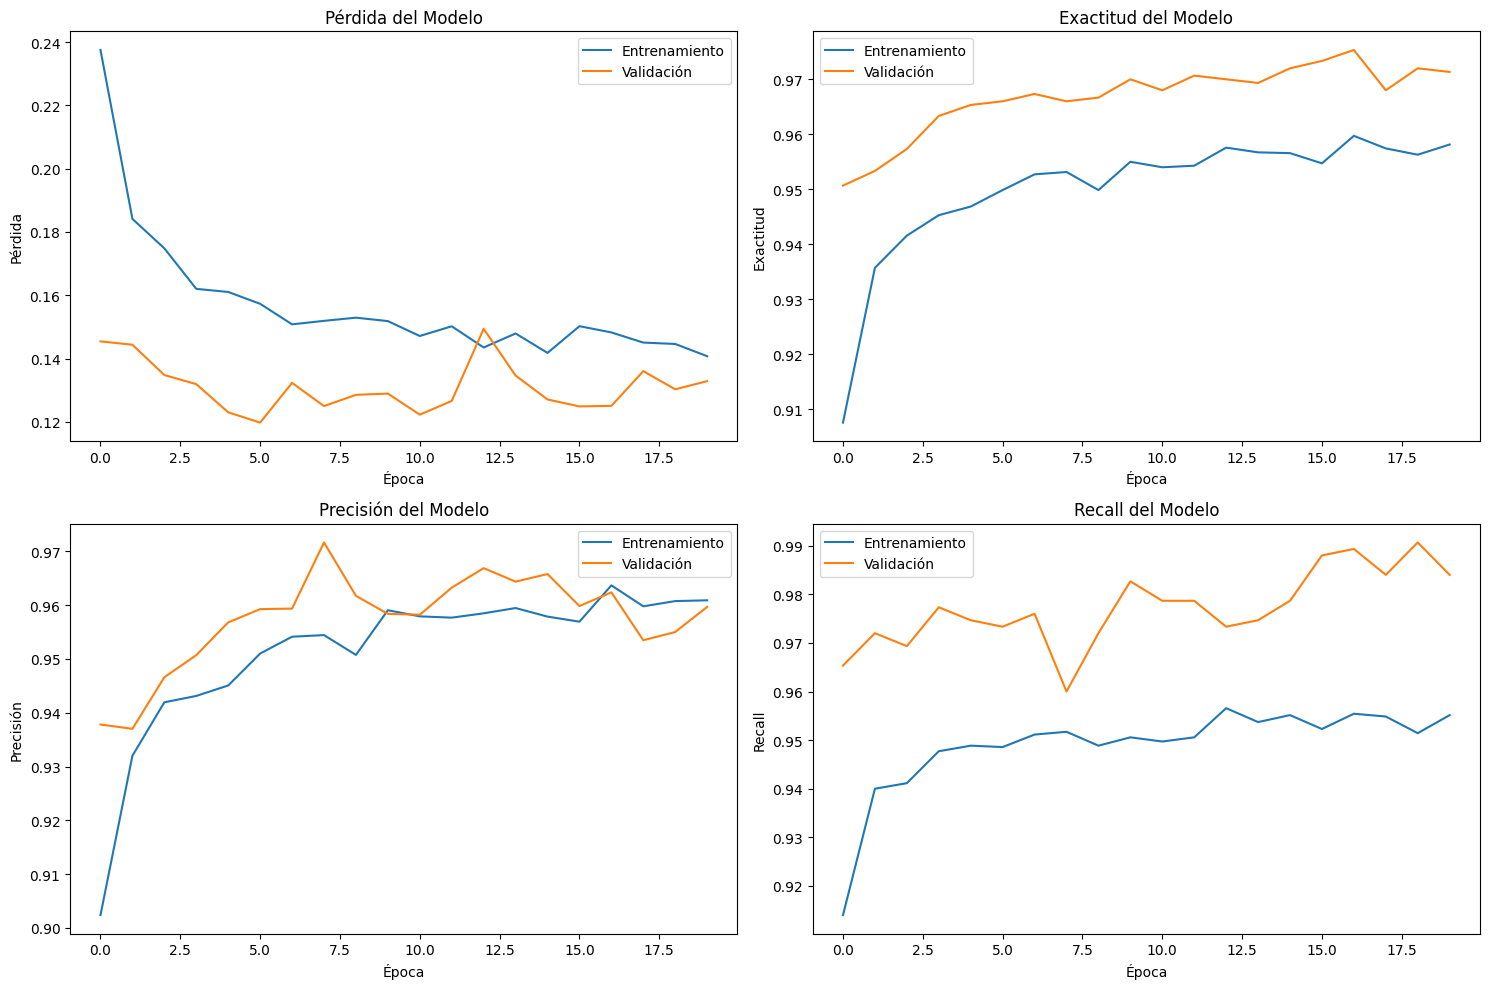

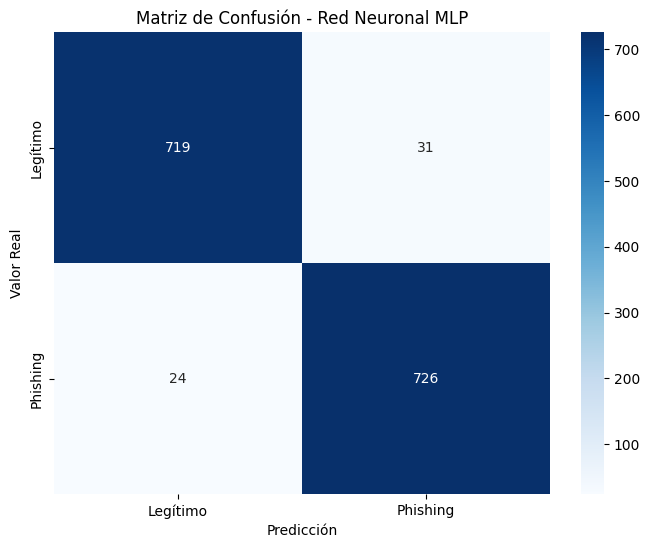


IMPLEMENTACIÓN COMPLETADA SEGÚN METODOLOGÍA


In [13]:
# Inicializar el modelo
nn_model = PhishingNeuralNetwork(random_state=42)

# Preparar los datos según metodología (70%-15%-15%)
X_train, X_val, X_test, y_train, y_val, y_test = nn_model.prepare_data(X, y)

# Optimización de hiperparámetros
best_hyperparams = nn_model.optimize_hyperparameters(
    X_train, y_train, X_val, y_val, 
    max_trials=20,  # Reducido para demo, usar 50+ en producción
    epochs=20       # Reducido para demo, usar 100+ en producción
)

# Entrenar modelo final con mejores hiperparámetros
final_model = nn_model.train_best_model(
    X_train, y_train, X_val, y_val, 
    best_hyperparams, epochs=20
)

# Evaluación final en conjunto de prueba
print("\n" + "="*60)
print("EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA")
print("="*60)

test_metrics = nn_model.evaluate_model(X_test, y_test)

print(f"\nMétricas principales:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1_score']:.4f}")
print(f"AUC-ROC: {test_metrics['auc_roc']:.4f}")

print(f"\nMétricas complementarias:")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"Matthews Correlation Coefficient: {test_metrics['mcc']:.4f}")

# Verificar criterios de selección según metodología
print(f"\n" + "="*60)
print("VERIFICACIÓN DE CRITERIOS DE SELECCIÓN")
print("="*60)

print(f"✓ F1-Score maximizado: {test_metrics['f1_score']:.4f}")
print(f"{'✓' if test_metrics['auc_roc'] >= 0.90 else '✗'} AUC-ROC ≥ 0.90: {test_metrics['auc_roc']:.4f}")

# Visualizaciones
nn_model.plot_training_history()
nn_model.plot_confusion_matrix(test_metrics['confusion_matrix'])

print(f"\n" + "="*60)
print("IMPLEMENTACIÓN COMPLETADA SEGÚN METODOLOGÍA")
print("="*60)